In [98]:
import numpy as np
import matplotlib.pyplot as plt
import random
import itertools
import ProjectPacks as pp
%matplotlib inline

from IPython.display import HTML 
HTML('../style/course.css') #apply general CSS

from scipy.optimize import leastsq
plt.rcParams['figure.figsize'] = (18, 6)  #spreads out plot surface for better visualization

from IPython.display import HTML
HTML('../style/code_toggle.html')

In [99]:
def modfunc(x, u_ant, v_ant):
    """
    Returns a vector containing the values of a 3x3 model exponential matrix with source parameters A0,l0,m0.
    
    INPUTS:
    x               Vector of source parameters.  Amp,l,m= x[0],x[1],x[2]  
    u_ant, v_ant    Value of (u,v)baseline measurements at the sampled (timeslot) points.
    """
    
    nbl= u_ant.shape[0] #3
    
    l= x[0]
    m= x[1]
    Amp= x[2]
    
    model= Amp*np.exp(-2j*np.pi*(u_ant*l+v_ant*m))
    model[range(nbl), range(nbl), :]= 0
    
    model_stream= model[np.where(model!=0)]
    ## with t timeslots each
    return model_stream

In [100]:
def modfunc_jac(x,u_ant,v_ant):
    """
    Returns the Hessian and Jacobian corresponding to the function defined by model equation.
    
    INPUTS:
    x               Vector of source parameters.  A,l,m= x[0],x[1],x[2] 
    u_ant, v_ant    Value of (u,v)baseline measurements at the sampled (timeslot) points. use this as a loop
   
    """
    t= u_ant.shape[2]
    nbl= u_ant.shape[0]
    
    l= x[0]
    m= x[1]
    Amp= x[2]
    
    ## Calculating JHJ explicitly from J
    Psi= -2j*np.pi*(u_ant*l+v_ant*m)
    expPsi= lambda sign: np.exp(sign*Psi)
    
    coeU = -2j*np.pi*Amp*u_ant
    coeV = -2j*np.pi*Amp*v_ant
    ## remember the -(minus) for negative exponents

    Jkl= coeU*expPsi(1) 
    Jkl[range(nbl), range(nbl), :]=0
    
    Jkm= coeV*expPsi(1) 
    Jkm[range(nbl), range(nbl), :]=0
      
    JkA= expPsi(1)
    JkA[range(nbl), range(nbl), :]=0
    
    
    Jk= np.vstack((Jkl[np.where(Jkl!=0)],Jkm[np.where(Jkm!=0)],JkA[np.where(Jkl!=0)])).T 
    
    Jh= Jk.conj().T ## Hermitian of J
    Complete= Jh.dot(Jk)
    
    Jh2= Jh[:-1,:]
    Complete2= Complete[:-1,:-1] ## 2 parameter case_only position
    
    return Jh,Complete


In [101]:
def modfunc_res(x, u_ant, v_ant, data):
    """
    Returns a vector containing the residual values over timeslots.
    
    INPUTS:
    data            Vector of measured values.
    u_ant, v_ant    Value of (u,v)baseline measurements at the sampled (timeslot) points.
    x               Vector of source parameters.  A,l,m= x[0],x[1],x[2]    
    """
    
    residual= data - modfunc(x, u_ant, v_ant)
    
    return residual

In [112]:
## Choose number of timeslots
timeslots= 200
Amp_no,l_no,m_no,ut,vt,SNum,ArNum,arrayHxpos=pp.formatSParams('Array_Profile.txt','Field_Profile.txt',td=timeslots)

t = np.arange(0, 5, 5/timeslots)          #The points at which we will be taking our "measurements"
noise = 0.000*np.random.normal(size=(2*t.shape[0])*len(ut)) #A noise vector used to manufacture "real" measurements.

x_true = np.array([np.radians(0.4), np.radians(0.5),np.radians(4)])          #The true (starting) values of our parameter vector (for alg).
x_con = np.array([np.radians(0.45), np.radians(0.55),np.radians(10)])

x_start= x_con.copy()

d = modfunc(x_true, ut, vt) + noise #Our "observed" data, contructed from our true parameter values and the noise vector.
m = modfunc(x_con, ut, vt)              #Our fitted function using the initial guess parameters.
r = modfunc_res(x_con, ut, vt, d)

In [ ]:
(10-1)*(timeslots/(11-1))  ##position in the grid

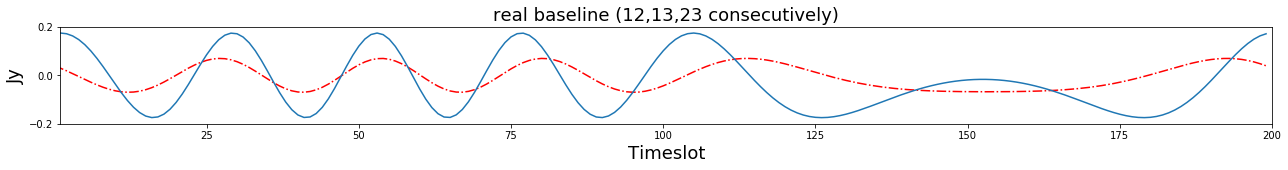

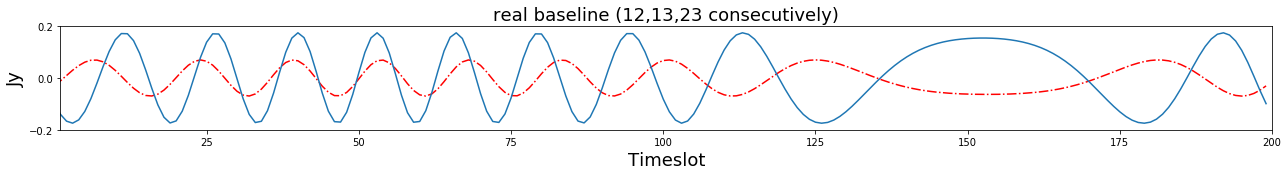

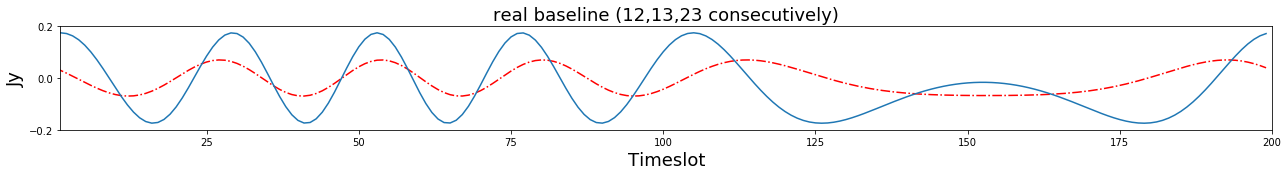

In [113]:
subps=["311","312","312"]

plt.figure()
for j in range(len(ut)):
    ax = plt.subplot(subps[j])
    ax.set_title("real baseline (12,13,23 consecutively)", fontsize=18)
    ax.plot(range(timeslots),d[j*t.shape[0]:(j+1)*t.shape[0]].real,'r-.')
    ax.plot(range(timeslots),m[j*t.shape[0]:(j+1)*t.shape[0]].real)
    ax.set_xlabel("Timeslot", fontsize=18)
    ax.set_ylabel("Jy", fontsize=18)
    ax.set_xlim([1,t.shape[0]])
    y_t = ax.get_yticks()
    y_t = y_t[::2]
    ax.set_yticks(y_t)

    plt.tight_layout()
    plt.show()

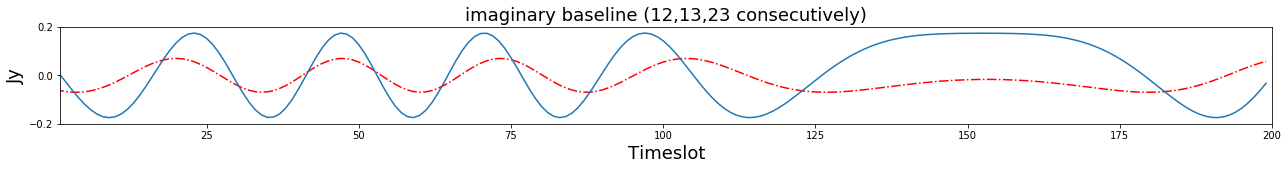

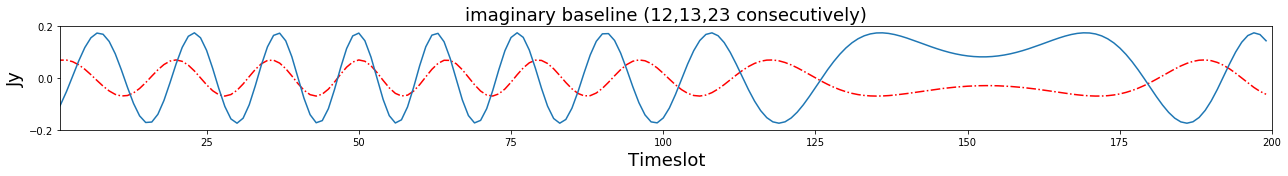

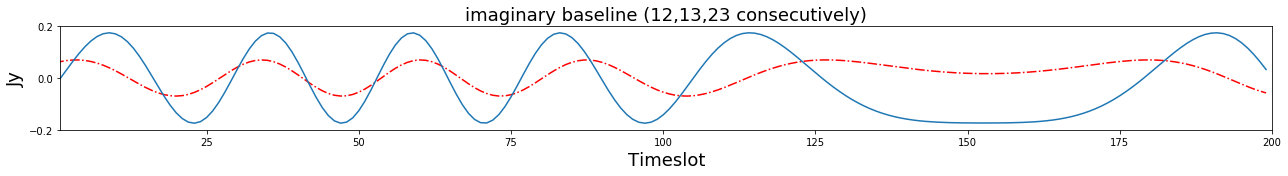

In [114]:
subps=["311","312","312"]

plt.figure()
for j in range(len(ut)):
    ax = plt.subplot(subps[j])
    ax.set_title("imaginary baseline (12,13,23 consecutively)", fontsize=18)
    ax.plot(range(timeslots),d[j*t.shape[0]:(j+1)*t.shape[0]].imag,'r-.')
    ax.plot(range(timeslots),m[j*t.shape[0]:(j+1)*t.shape[0]].imag)
    ax.set_xlabel("Timeslot", fontsize=18)
    ax.set_ylabel("Jy", fontsize=18)
    ax.set_xlim([1,t.shape[0]])
    y_t = ax.get_yticks()
    y_t = y_t[::2]
    ax.set_yticks(y_t)

    plt.tight_layout()
    plt.show()

In [115]:
## trying out real case first
def levenberg_marquardt(data, u_ant, v_ant, x, r_func, j_func, maxit=100, lamda=1, K=10, eps1=1e-6, eps2=1e-6):
    """
    Returns a vector containing the optimal parameter values found by the algorithm.
    
    INPUTS:
    d         Vector of measured values.
    t         Value of independent variable at the sampled points. (300)
    x         Vector of parameters. (1,3)
    r_func    Function which generates the residual vector. (1,900)
    j_func    Function which generates the (Conjugate of) Jacobian & the Hessian. (3,900) & (3,3) 
    maxiter   Maximum number of iterations.
    lamda     Initial value of tuning parameter.
    K         Initial value of retuning factor.
    eps1      First tolerance parameter - triggers when residual is below this number.
    eps2      Second tolerance parameter - triggers when relative changes to the parameter
              vector are below this number.
    """
    
    #Initialises some important values and stores the original lamda value.
    
    r = r_func(x, u_ant, v_ant, data)
    print("Shape of residual vec: ", np.shape(r))
    old_chi = np.linalg.norm(r)
    olamda = lamda
    it = 0
    
    chiplot=[]
    chiplot.append(old_chi)
    
    solpath= x
    
    while True:
        
        #Heavy lifting portion of the algorithm. Computes the parameter update.
        #This is just the implementation of the mathmatical update rule.
        JH,JHJ = j_func(x,u_ant,v_ant)
        
        JHJdiag = np.diag(np.diag(JHJ))
        #this says there is a different D for each timeslot
        #lamda = 1 if (it%2==0) else 0
        JHJinv= np.linalg.pinv(JHJ+lamda*JHJdiag)
        JHr = JH.dot(r)
        
        delta_x = JHJinv.dot(JHr)        
        x += delta_x.real
        
        solpath= np.vstack((solpath,x))        
        
        #Convergence tests. If a solution has been found, returns the result.
        #The chi value is the norm of the residual and is used to determine
        #whether the solution is improving. If the chi value is sufficiently 
        #small, the function terminates. The second test checks to see whether
        #or not the solution is improving, and terminates if it isn't.
        
        r = r_func(x, u_ant, v_ant, data)
        new_chi = np.linalg.norm(r)
        chiplot.append(new_chi)
        
        if new_chi < eps1:
            return x,chiplot,solpath
        elif np.linalg.norm(delta_x.real) < eps2*(np.linalg.norm(x) + eps2):
            return x,chiplot,solpath
        
        #Tuning stage. If the parameter update was good, continue and restore lamda.
        #If the update was bad, scale lamda by K and revert last update.
        
        if new_chi > old_chi:
            x -= delta_x.real
            lamda = lamda*K
        else:
            old_chi = new_chi
            lamda = olamda
            
        #If the number of iterations grows too large, return the last value of x.
        
        it += 1
            
        if it >= maxit:
            return x,chiplot,solpath


In [116]:
solved_x,cplot,spath = levenberg_marquardt(d,ut,vt,x_con,modfunc_res,modfunc_jac)
print("solved x: ", solved_x)
print("true x: ", x_true)
print("model x: ",  x_start) #got from up there

Shape of residual vec:  (1200,)
solved x:  [ 0.00698132  0.00872665  0.06981312]
true x:  [ 0.00698132  0.00872665  0.06981317]
model x:  [ 0.00785398  0.00959931  0.17453293]


In [117]:
print(spath)
print(np.shape(spath))

[[ 0.00778993  0.00953494  0.09499546]
 [ 0.00778993  0.00953494  0.09499546]
 [ 0.0076626   0.00940714  0.05761217]
 [ 0.00743283  0.00917702  0.04410288]
 [ 0.00715416  0.00889876  0.0469434 ]
 [ 0.00703014  0.00877524  0.05675422]
 [ 0.0070002   0.00874544  0.06315204]
 [ 0.00698977  0.00873506  0.06646289]
 [ 0.00698533  0.00873064  0.06813408]
 [ 0.00698327  0.00872859  0.06897274]
 [ 0.00698228  0.00872761  0.06939274]
 [ 0.0069818   0.00872712  0.0696029 ]
 [ 0.00698156  0.00872688  0.06970802]
 [ 0.00698144  0.00872677  0.06976059]
 [ 0.00698138  0.00872671  0.06978688]
 [ 0.00698135  0.00872668  0.06980003]
 [ 0.00698133  0.00872666  0.0698066 ]
 [ 0.00698132  0.00872665  0.06980988]
 [ 0.00698132  0.00872665  0.06981153]
 [ 0.00698132  0.00872665  0.06981235]
 [ 0.00698132  0.00872665  0.06981276]
 [ 0.00698132  0.00872665  0.06981296]
 [ 0.00698132  0.00872665  0.06981307]
 [ 0.00698132  0.00872665  0.06981312]]
(24, 3)


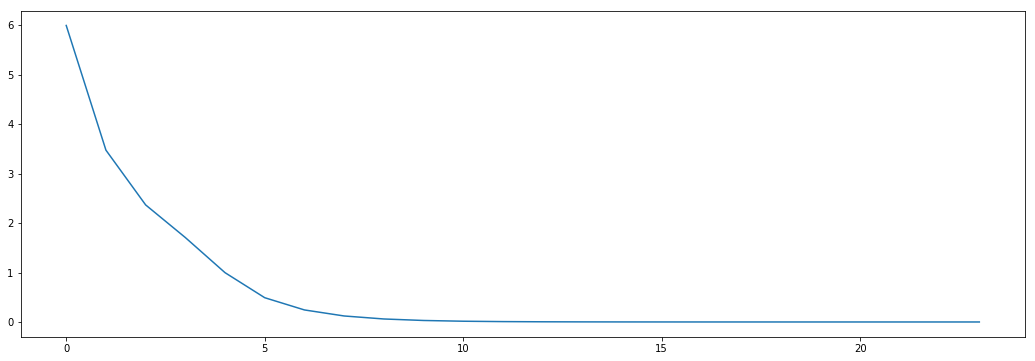

In [118]:
plt.plot(cplot)
plt.show()

In [157]:
L= np.radians(np.arange(-1,1,2/timeslots))
M= np.radians(np.arange(-1,1,2/timeslots))
A= np.radians(np.arange(1,11,10/timeslots))

rr_constA= np.empty((timeslots,timeslots))
rr_constM= np.empty((timeslots,timeslots))
rr_constL= np.empty((timeslots,timeslots))

for a in range(timeslots):
    for b in range(timeslots):
        
        x_r= [L[a],M[b],x_true[2]]
        rr_constA[a,b]= np.square(np.linalg.norm(modfunc_res(x_r,ut,vt,d)))
        
for a in range(timeslots):
    for b in range(timeslots):
        
        x_r= [L[a],x_true[1],A[b]]
        rr_constM[a,b]= np.square(np.linalg.norm(modfunc_res(x_r,ut,vt,d)))
        
for a in range(timeslots):
    for b in range(timeslots):
        
        x_r= [x_true[0],M[a],A[b]]
        rr_constL[a,b]= np.square(np.linalg.norm(modfunc_res(x_r,ut,vt,d)))
        
Minimum_A= np.unravel_index(np.argmin(rr_constA),rr_constA.shape)
print("Minimum of (L,M) at: ", Minimum_A)
print(rr_constA[Minimum_A])

Minimum_M= np.unravel_index(np.argmin(rr_constM),rr_constM.shape)
print("Minimum of (L,A) at: ", Minimum_M)
print(rr_constM[Minimum_M])

Minimum_L= np.unravel_index(np.argmin(rr_constL),rr_constL.shape)
print("Minimum of (M,A) at: ",Minimum_L)
print(rr_constL[Minimum_L])

Minimum of (L,M) at:  (140, 150)
9.13234018974e-27
Minimum of (L,A) at:  (140, 60)
4.81840213648e-27
Minimum of (M,A) at:  (150, 60)
4.3642263349e-27


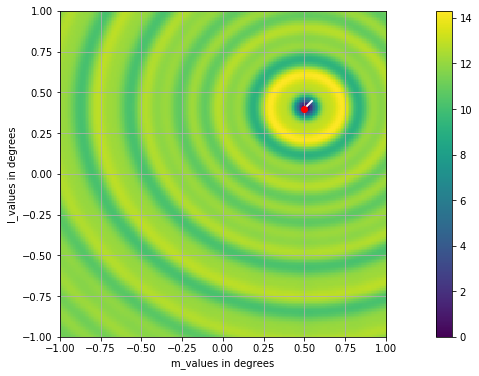

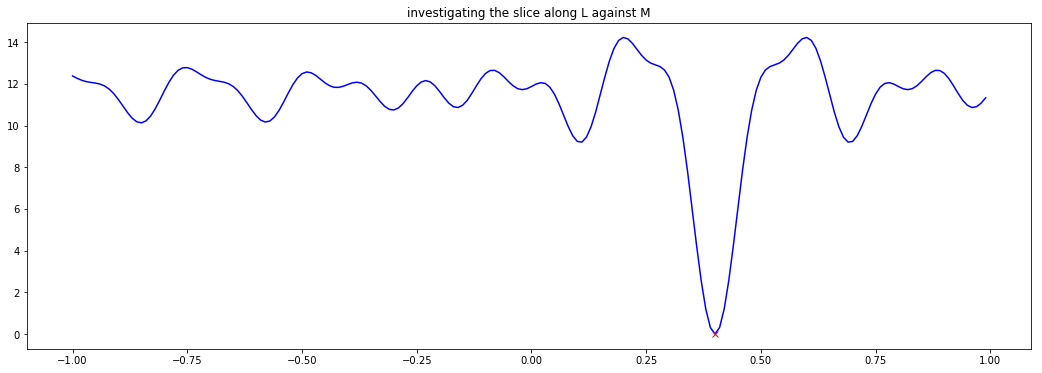

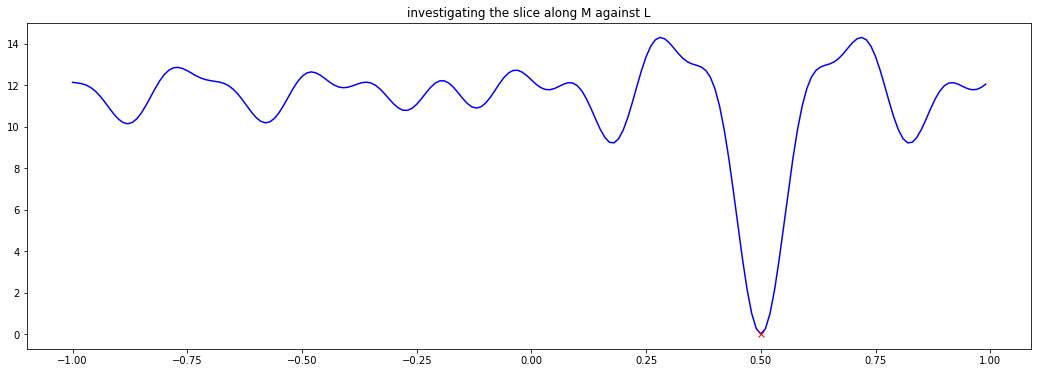

In [159]:
plt.imshow(np.flipud(rr_constA), extent=[-1,1,-1,1])
plt.plot(spath[:,1,]*180/np.pi, spath[:,0]*180/np.pi, 'w',lw=2)
plt.plot(x_true[1]*180/np.pi,x_true[0]*180/np.pi,'ro',lw=1)
plt.colorbar()
plt.grid()
plt.xlabel("m_values in degrees")
plt.ylabel("l_values in degrees")
plt.title("Contour mapping of L,M, constant A")
plt.show()

plt.plot(L*180/np.pi,rr_constA[:,Minimum_A[1]], 'b', x_true[0]*180/np.pi,[0],'rx')
plt.title("investigating the slice along L against constant true M")
plt.show()
plt.plot(M*180/np.pi,rr_constA[Minimum_A[0],:], 'b', x_true[1]*180/np.pi,[0],'rx')
plt.title("investigating the slice along M against constant true L")
plt.show()

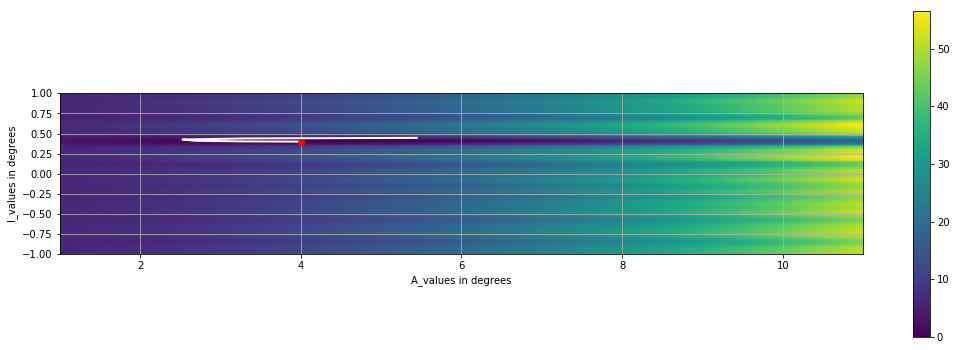

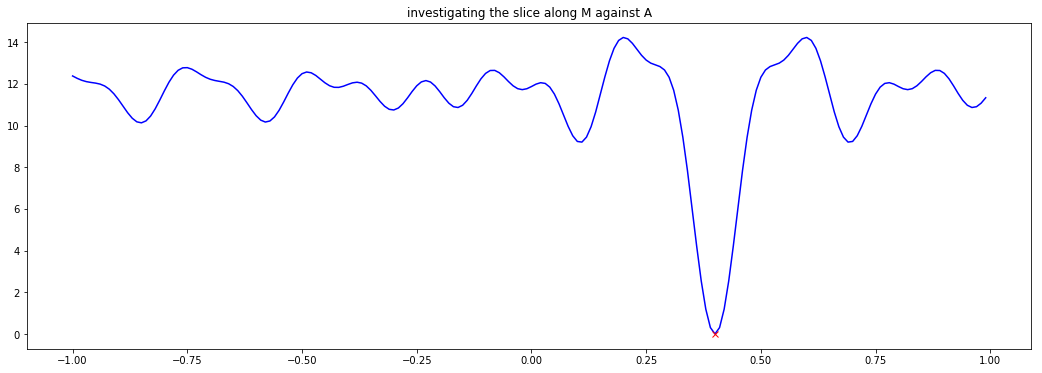

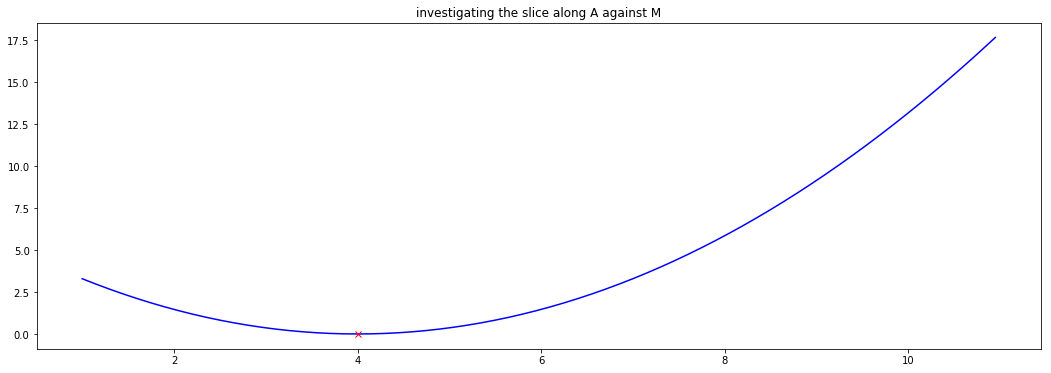

In [160]:
plt.imshow(np.flipud(rr_constM), extent=[1,11,-1,1])
plt.plot(spath[:,2]*180/np.pi, spath[:,0]*180/np.pi, 'w',lw=2)
plt.plot(x_true[2]*180/np.pi,x_true[0]*180/np.pi,'ro',lw=1)
plt.colorbar()
plt.grid()
plt.xlabel("A_values in degrees")
plt.ylabel("l_values in degrees")
plt.title("Contour mapping of L,A, constant M")
plt.show()

plt.plot(L*180/np.pi,rr_constM[:,Minimum_M[1]], 'b', x_true[0]*180/np.pi,[0],'rx')
plt.title("investigating the slice along M against constant true A")
plt.show()
plt.plot(A*180/np.pi,rr_constM[Minimum_M[0],:], 'b', x_true[2]*180/np.pi,[0],'rx')
plt.title("investigating the slice along A against constant true M")
plt.show()


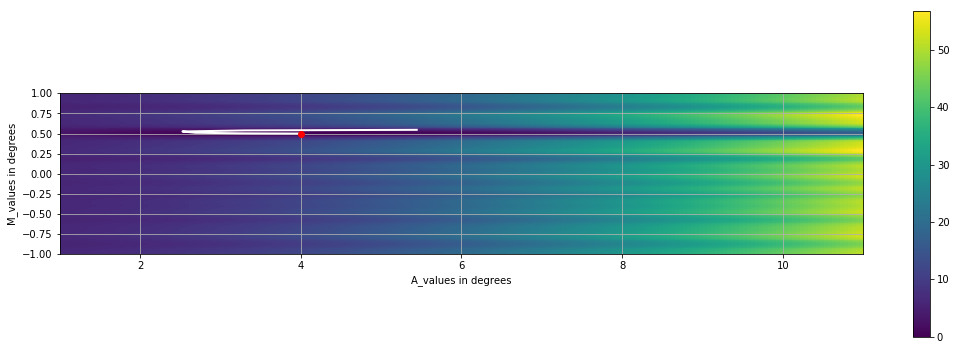

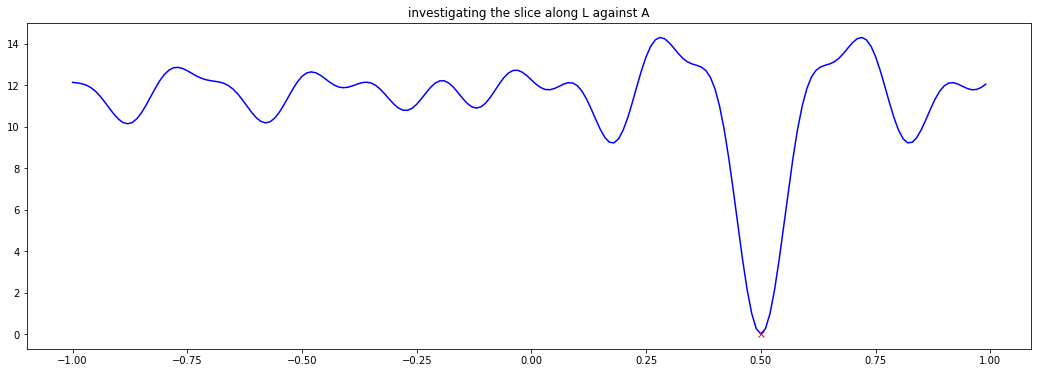

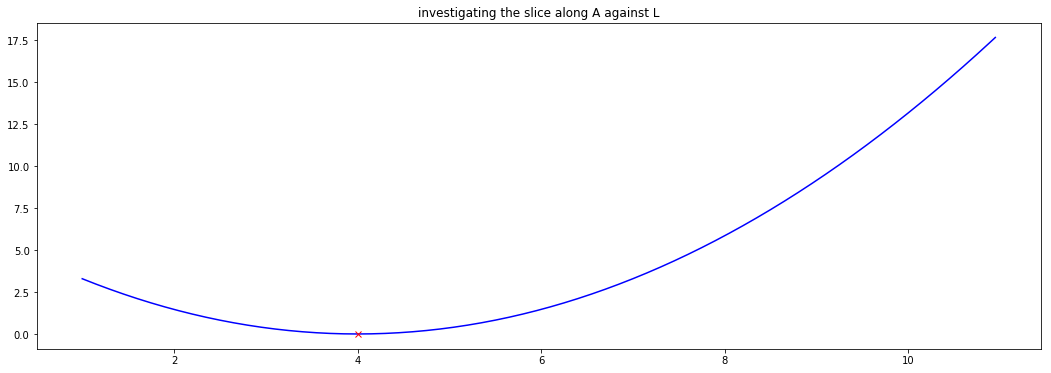

In [162]:
plt.imshow(np.flipud(rr_constL), extent=[1,11,-1,1])
plt.plot(spath[:,2]*180/np.pi, spath[:,1]*180/np.pi, 'w',lw=2)
plt.plot(x_true[2]*180/np.pi,x_true[1]*180/np.pi,'ro',lw=1)
plt.colorbar()
plt.grid()
plt.xlabel("A_values in degrees")
plt.ylabel("M_values in degrees")
plt.title("Contour mapping of M,A constant L")
plt.show()

plt.plot(M*180/np.pi,rr_constL[:,Minimum_L[1]], 'b', x_true[1]*180/np.pi,[0],'rx')
plt.title("investigating the slice along L against constant true A")
plt.show()
plt.plot(A*180/np.pi,rr_constL[Minimum_L[0],:], 'b', x_true[2]*180/np.pi,[0],'rx')
plt.title("investigating the slice along A against constant true L")
plt.show()


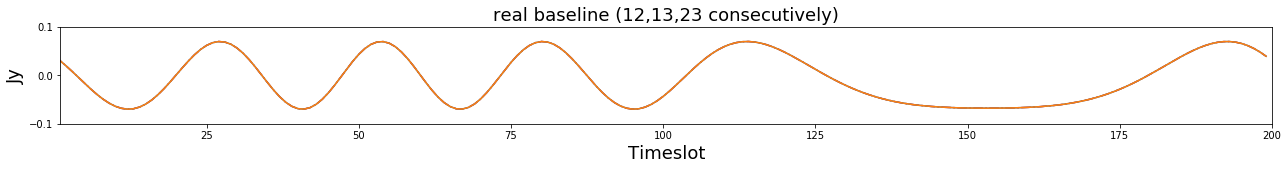

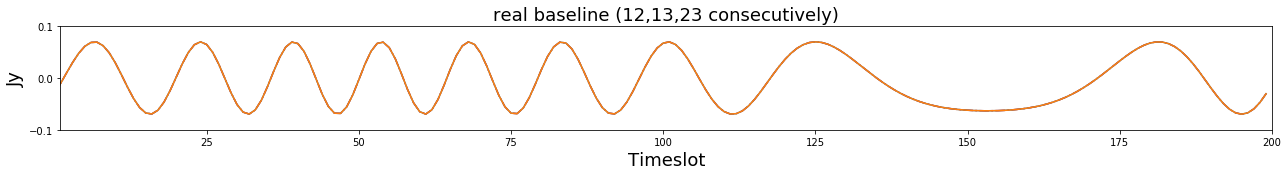

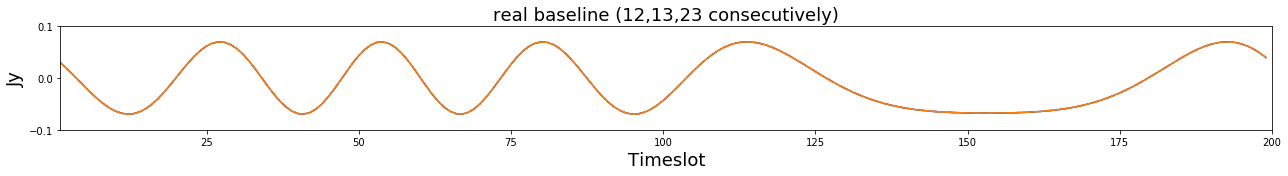

In [123]:
subps=["311","312","312"]

plt.figure()
for j in range(len(ut)):
    ax = plt.subplot(subps[j])
    ax.set_title("real baseline (12,13,23 consecutively)", fontsize=18)
    ax.plot(range(timeslots),d[j*t.shape[0]:(j+1)*t.shape[0]].real,'r-.')
    ax.plot(range(timeslots),modfunc(solved_x,ut,vt)[j*t.shape[0]:(j+1)*t.shape[0]].real)
    ax.plot(range(timeslots),modfunc(x_true,ut,vt)[j*t.shape[0]:(j+1)*t.shape[0]].real)
    ax.set_xlabel("Timeslot", fontsize=18)
    ax.set_ylabel("Jy", fontsize=18)
    ax.set_xlim([1,t.shape[0]])
    y_t = ax.get_yticks()
    y_t = y_t[::2]
    ax.set_yticks(y_t)

    plt.tight_layout()
    plt.show()


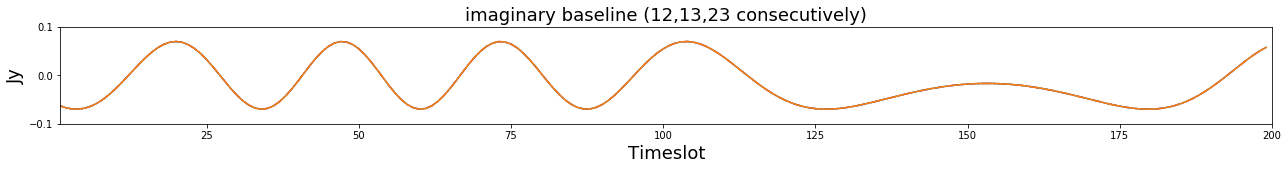

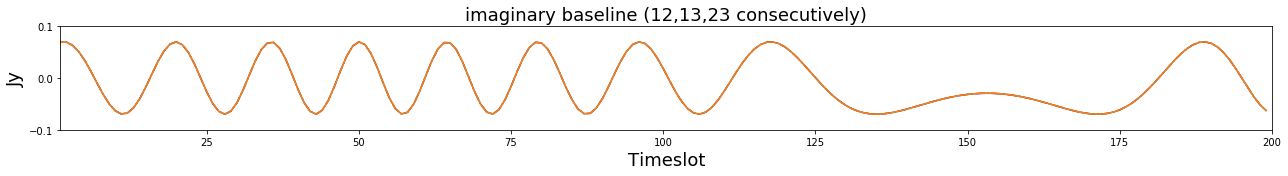

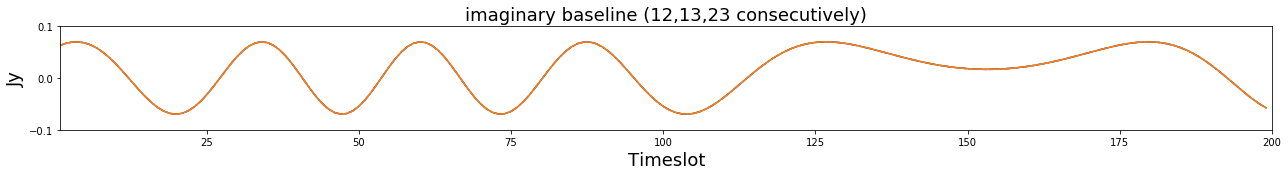

In [124]:
subps=["311","312","312"]

plt.figure()
for j in range(len(ut)):
    ax = plt.subplot(subps[j])
    ax.set_title("imaginary baseline (12,13,23 consecutively)", fontsize=18)
    ax.plot(range(timeslots),d[j*t.shape[0]:(j+1)*t.shape[0]].imag,'r-.')
    ax.plot(range(timeslots),modfunc(solved_x,ut,vt)[j*t.shape[0]:(j+1)*t.shape[0]].imag)
    ax.plot(range(timeslots),modfunc(x_true,ut,vt)[j*t.shape[0]:(j+1)*t.shape[0]].imag)
    ax.set_xlabel("Timeslot", fontsize=18)
    ax.set_ylabel("Jy", fontsize=18)
    ax.set_xlim([1,t.shape[0]])
    y_t = ax.get_yticks()
    y_t = y_t[::2]
    ax.set_yticks(y_t)

    plt.tight_layout()
    plt.show()

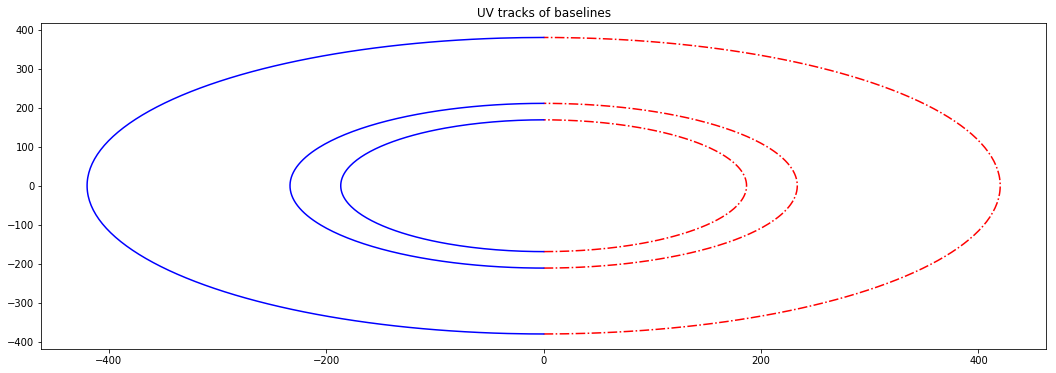

In [125]:
for k in range(ArNum):
    for i in range(k,ArNum):
        plt.plot(ut[k][i],vt[k][i],"r-.", ut[i][k],vt[i][k],"b-")
        
plt.title("UV tracks of baselines")
plt.show()